<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 1832, '日付': '2021-07-21T08:00:00.000Z'},
 {'小計': 1979, '日付': '2021-07-22T08:00:00.000Z'},
 {'小計': 1359, '日付': '2021-07-23T08:00:00.000Z'},
 {'小計': 1128, '日付': '2021-07-24T08:00:00.000Z'},
 {'小計': 1763, '日付': '2021-07-25T08:00:00.000Z'},
 {'小計': 1429, '日付': '2021-07-26T08:00:00.000Z'},
 {'小計': 2848, '日付': '2021-07-27T08:00:00.000Z'},
 {'小計': 3177, '日付': '2021-07-28T08:00:00.000Z'},
 {'小計': 3865, '日付': '2021-07-29T08:00:00.000Z'},
 {'小計': 3300, '日付': '2021-07-30T08:00:00.000Z'},
 {'小計': 4058, '日付': '2021-07-31T08:00:00.000Z'},
 {'小計': 3058, '日付': '2021-08-01T08:00:00.000Z'},
 {'小計': 2195, '日付': '2021-08-02T08:00:00.000Z'},
 {'小計': 3709, '日付': '2021-08-03T08:00:00.000Z'},
 {'小計': 4166, '日付': '2021-08-04T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-07-31 17:00:00+09:00,1629,0,4058,2021-07-31 17:00:00+09:00
2021-08-01 17:00:00+09:00,1528,0,3058,2021-08-01 17:00:00+09:00
2021-08-02 17:00:00+09:00,1594,0,2195,2021-08-02 17:00:00+09:00
2021-08-03 17:00:00+09:00,1384,0,3709,2021-08-03 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-07-31 17:00:00+09:00,1629,0,4058,2021-07-31 17:00:00+09:00,1185.857143,8301.0,0.0,0.0,2920.000000,20440.0
2021-08-01 17:00:00+09:00,1528,0,3058,2021-08-01 17:00:00+09:00,1283.857143,8987.0,0.0,0.0,3105.000000,21735.0
2021-08-02 17:00:00+09:00,1594,0,2195,2021-08-02 17:00:00+09:00,1365.571429,9559.0,0.0,0.0,3214.428571,22501.0
2021-08-03 17:00:00+09:00,1384,0,3709,2021-08-03 17:00:00+09:00,1417.571429,9923.0,0.0,0.0,3337.428571,23362.0
2021-08-04 17:00:00+09:00,0,0,4166,2021-08-04 17:00:00+09:00,1241.142857,8688.0,0.0,0.0,3478.714286,24351.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-07-21 17:00:00+09:00,724,0,1832,2021-07-21 17:00:00+09:00,614.428571,4301.0,0.0,0.0,1277.571429,8943.0,'21w29,Wed
2021-07-22 17:00:00+09:00,907,0,1979,2021-07-22 17:00:00+09:00,664.142857,4649.0,0.0,0.0,1373.428571,9614.0,'21w29,Thu
2021-07-23 17:00:00+09:00,801,0,1359,2021-07-23 17:00:00+09:00,693.571429,4855.0,0.0,0.0,1386.000000,9702.0,'21w29,Fri
2021-07-24 17:00:00+09:00,922,0,1128,2021-07-24 17:00:00+09:00,723.714286,5066.0,0.0,0.0,1345.714286,9420.0,'21w29,Sat
2021-07-25 17:00:00+09:00,842,0,1763,2021-07-25 17:00:00+09:00,768.857143,5382.0,0.0,0.0,1453.571429,10175.0,'21w29,Sun
2021-07-26 17:00:00+09:00,1022,0,1429,2021-07-26 17:00:00+09:00,828.714286,5801.0,0.0,0.0,1553.857143,10877.0,'21w30,Mon
2021-07-27 17:00:00+09:00,1020,0,2848,2021-07-27 17:00:00+09:00,891.142857,6238.0,0.0,0.0,1762.571429,12338.0,'21w30,Tue
2021-07-28 17:00:00+09:00,1235,0,3177,2021-07-28 17:00:00+09:00,964.142857,6749.0,0.0,0.0,1954.714286,13683.0,'21w30,Wed
2021-07-29 17:00:00+09:00,1287,0,3865,2021-07-29 17:00:00+09:00,1018.428571,7129.0,0.0,0.0,2224.142857,15569.0,'21w30,Thu
2021-07-30 17:00:00+09:00,1266,0,3300,2021-07-30 17:00:00+09:00,1084.857143,7594.0,0.0,0.0,2501.428571,17510.0,'21w30,Fri


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-07-18 17:00:00+09:00,1068.285714,7478
2021-07-25 17:00:00+09:00,1453.571429,10175
2021-08-01 17:00:00+09:00,3105.000000,21735
2021-08-04 17:00:00+09:00,3356.666667,10070
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-07-21 17:00:00+09:00,724,0,1832,2021-07-21 17:00:00+09:00,614.428571,4301.0,0.0,0.0,1277.571429,8943.0,'21w29,Wed,NaN,NaN
2021-07-22 17:00:00+09:00,907,0,1979,2021-07-22 17:00:00+09:00,664.142857,4649.0,0.0,0.0,1373.428571,9614.0,'21w29,Thu,NaN,NaN
2021-07-23 17:00:00+09:00,801,0,1359,2021-07-23 17:00:00+09:00,693.571429,4855.0,0.0,0.0,1386.000000,9702.0,'21w29,Fri,NaN,NaN
2021-07-24 17:00:00+09:00,922,0,1128,2021-07-24 17:00:00+09:00,723.714286,5066.0,0.0,0.0,1345.714286,9420.0,'21w29,Sat,NaN,NaN
2021-07-25 17:00:00+09:00,842,0,1763,2021-07-25 17:00:00+09:00,768.857143,5382.0,0.0,0.0,1453.571429,10175.0,'21w29,Sun,1453.571429,10175.0
2021-07-26 17:00:00+09:00,1022,0,1429,2021-07-26 17:00:00+09:00,828.714286,5801.0,0.0,0.0,1553.857143,10877.0,'21w30,Mon,NaN,NaN
2021-07-27 17:00:00+09:00,1020,0,2848,2021-07-27 17:00:00+09:00,891.142857,6238.0,0.0,0.0,1762.571429,12338.0,'21w30,Tue,NaN,NaN
2021-07-28 17:00:00+09:00,1235,0,3177,2021-07-28 17:00:00+09:00,964.142857,6749.0,0.0,0.0,1954.714286,13683.0,'21w30,Wed,NaN,NaN
2021-07-29 17:00:00+09:00,1287,0,3865,2021-07-29 17:00:00+09:00,1018.428571,7129.0,0.0,0.0,2224.142857,15569.0,'21w30,Thu,NaN,NaN
2021-07-30 17:00:00+09:00,1266,0,3300,2021-07-30 17:00:00+09:00,1084.857143,7594.0,0.0,0.0,2501.428571,17510.0,'21w30,Fri,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

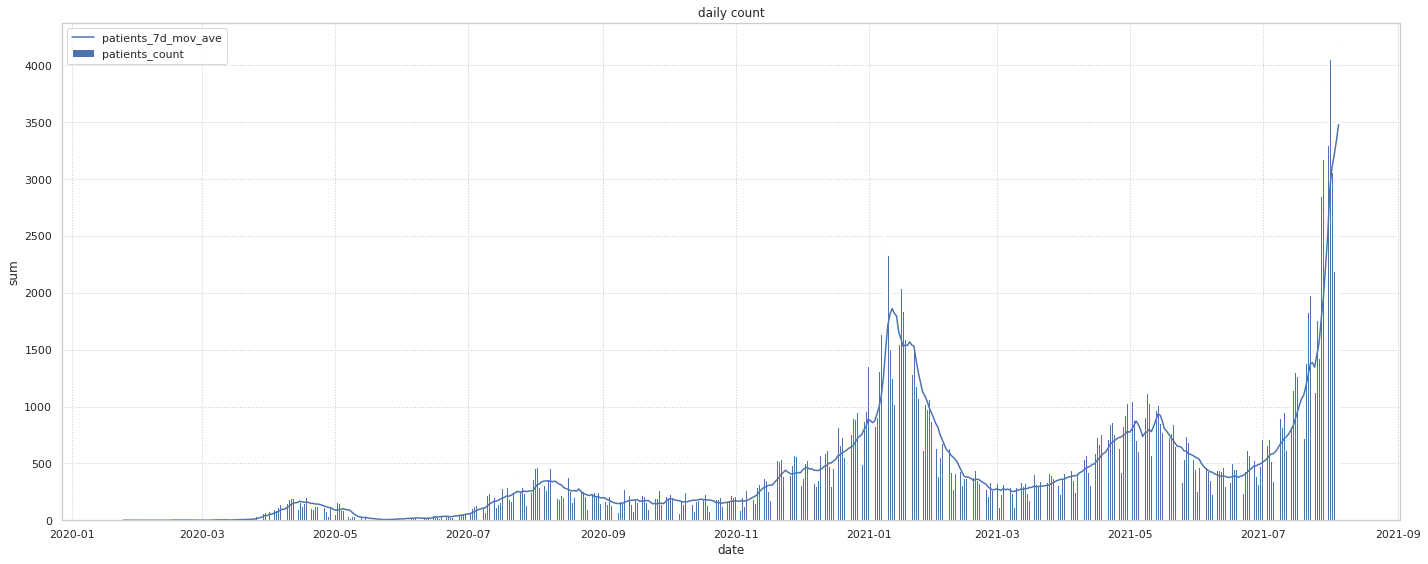

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
544,1.626854e+09,2021,7,21,0,0,0,0,0,0,1,544,0,470,724,614.428571,4301.0,0,0.0,0.0,1832,1277.571429,8943.0
545,1.626941e+09,2021,7,22,0,0,0,0,1,0,0,545,0,471,907,664.142857,4649.0,0,0.0,0.0,1979,1373.428571,9614.0
546,1.627027e+09,2021,7,23,1,0,0,0,0,0,0,546,0,472,801,693.571429,4855.0,0,0.0,0.0,1359,1386.000000,9702.0
547,1.627114e+09,2021,7,24,0,0,1,0,0,0,0,547,0,473,922,723.714286,5066.0,0,0.0,0.0,1128,1345.714286,9420.0
548,1.627200e+09,2021,7,25,0,0,0,1,0,0,0,548,0,474,842,768.857143,5382.0,0,0.0,0.0,1763,1453.571429,10175.0
549,1.627286e+09,2021,7,26,0,1,0,0,0,0,0,549,0,475,1022,828.714286,5801.0,0,0.0,0.0,1429,1553.857143,10877.0
550,1.627373e+09,2021,7,27,0,0,0,0,0,1,0,550,0,476,1020,891.142857,6238.0,0,0.0,0.0,2848,1762.571429,12338.0
551,1.627459e+09,2021,7,28,0,0,0,0,0,0,1,551,0,477,1235,964.142857,6749.0,0,0.0,0.0,3177,1954.714286,13683.0
552,1.627546e+09,2021,7,29,0,0,0,0,1,0,0,552,0,478,1287,1018.428571,7129.0,0,0.0,0.0,3865,2224.142857,15569.0
553,1.627632e+09,2021,7,30,1,0,0,0,0,0,0,553,0,479,1266,1084.857143,7594.0,0,0.0,0.0,3300,2501.428571,17510.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            559 non-null    float64
 1   year                 559 non-null    int64  
 2   month                559 non-null    int64  
 3   day                  559 non-null    int64  
 4   Fri                  559 non-null    uint8  
 5   Mon                  559 non-null    uint8  
 6   Sat                  559 non-null    uint8  
 7   Sun                  559 non-null    uint8  
 8   Thu                  559 non-null    uint8  
 9   Tue                  559 non-null    uint8  
 10  Wed                  559 non-null    uint8  
 11  passed               559 non-null    int64  
 12  emergency            559 non-null    int64  
 13  em_passed            559 non-null    int64  
 14  contacts_count       559 non-null    int64  
 15  contacts_7d_mov_ave  559 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,5.590000e+02,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000
mean,1.603958e+09,2020.386404,5.805009,15.779964,0.143113,0.143113,0.143113,0.143113,0.141324,0.143113,0.143113,279.000000,0.087657,209.964222,660.146691,654.422140,4580.948122,659.246869,659.246869,4614.728086,413.409660,394.780808,2763.436494
std,1.395478e+07,0.487361,3.156533,8.888591,0.350501,0.350501,0.350501,0.350501,0.348667,0.350501,0.350501,161.513673,0.283048,154.194690,429.533751,413.643274,2895.513730,853.665075,772.033337,5404.233357,551.676271,474.765752,3323.384519
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.591906e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,139.500000,0.000000,65.500000,375.500000,379.500000,2656.500000,0.000000,0.000000,0.000000,86.000000,97.642857,683.500000
50%,1.603958e+09,2020.000000,5.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,279.000000,0.000000,205.000000,522.000000,530.285714,3712.000000,0.000000,0.000000,0.000000,256.000000,263.857143,1847.000000
75%,1.616011e+09,2021.000000,8.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,418.500000,0.000000,344.500000,776.500000,752.000000,5264.000000,1301.500000,1280.714286,8965.000000,534.500000,513.857143,3597.000000
max,1.628064e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,558.000000,1.000000,484.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,4166.000000,3478.714286,24351.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.843380,0.118925,0.005185,-0.006331,0.001266,-0.003799,-0.001266,-1.715149e-18,0.003799,0.006331,1.000000e+00,-0.347673,0.996612,-0.257315,-0.261660,-0.261655,-0.573856,-0.618644,-0.618644,0.598873,0.643496,0.643506
year,8.433803e-01,1.000000,-0.430891,-0.032464,0.000920,0.000920,0.000920,0.000920,-5.546758e-03,0.000920,0.000920,8.433803e-01,-0.245976,0.857841,-0.262045,-0.257393,-0.257390,-0.613379,-0.678236,-0.678236,0.543152,0.604030,0.604033
month,1.189252e-01,-0.430891,1.000000,-0.023505,-0.013608,0.000971,-0.008748,-0.003889,1.042835e-02,0.005830,0.009070,1.189252e-01,-0.127261,0.086281,0.053873,0.039052,0.039056,0.171867,0.217976,0.217976,-0.002207,-0.038305,-0.038291
day,5.185493e-03,-0.032464,-0.023505,1.000000,0.013577,-0.005406,0.006674,0.000347,-1.513402e-03,-0.012308,-0.001379,5.185493e-03,-0.003005,0.006421,0.001003,-0.012270,-0.012274,0.004625,-0.009011,-0.009011,0.029155,0.007657,0.007648
Fri,-6.331356e-03,0.000920,-0.013608,0.013577,1.000000,-0.167015,-0.167015,-0.167015,-1.657945e-01,-0.167015,-0.167015,-6.331356e-03,-0.000226,-0.005575,-0.017448,-0.006338,-0.006337,0.032117,-0.000624,-0.000624,0.021995,-0.011018,-0.011023
Mon,1.266271e-03,0.000920,0.000971,-0.005406,-0.167015,1.000000,-0.167015,-0.167015,-1.657945e-01,-0.167015,-0.167015,1.266271e-03,-0.000226,0.001289,0.041928,0.002051,0.002052,0.128655,-0.000624,-0.000624,-0.112049,0.003300,0.003302
Sat,-3.798814e-03,0.000920,-0.008748,0.006674,-0.167015,-0.167015,1.000000,-0.167015,-1.657945e-01,-0.167015,-0.167015,-3.798814e-03,-0.000226,-0.003287,0.047713,-0.003462,-0.003461,-0.149723,-0.000624,-0.000624,0.038001,-0.004776,-0.004780
Sun,-1.266271e-03,0.000920,-0.003889,0.000347,-0.167015,-0.167015,-0.167015,1.000000,-1.657945e-01,-0.167015,-0.167015,-1.266271e-03,-0.000226,-0.000999,-0.023149,-0.000764,-0.000763,-0.137990,-0.000624,-0.000624,-0.036301,-0.000075,-0.000075
Thu,-1.715149e-18,-0.005547,0.010428,-0.001513,-0.165795,-0.165795,-0.165795,-0.165795,1.000000e+00,-0.165795,-0.165795,-3.165655e-18,0.001364,-0.000906,-0.005093,-0.000487,-0.000486,0.041301,0.003762,0.003762,0.056038,-0.011915,-0.011911
Tue,3.798814e-03,0.000920,0.005830,-0.012308,-0.167015,-0.167015,-0.167015,-0.167015,-1.657945e-01,1.000000,-0.167015,3.798814e-03,-0.000226,0.003577,-0.021638,0.004495,0.004496,0.050990,-0.000624,-0.000624,-0.009804,0.009006,0.009008


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,1.627718e+09,0,0,1,0,0,0,0,554,0,480,1629,0,4058,2920.000000,20440.0
555,1.627805e+09,0,0,0,1,0,0,0,555,0,481,1528,0,3058,3105.000000,21735.0
556,1.627891e+09,0,1,0,0,0,0,0,556,0,482,1594,0,2195,3214.428571,22501.0
557,1.627978e+09,0,0,0,0,0,1,0,557,0,483,1384,0,3709,3337.428571,23362.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
554,1.627718e+09,554,0,4058,2920.000000,20440.0
555,1.627805e+09,555,0,3058,3105.000000,21735.0
556,1.627891e+09,556,0,2195,3214.428571,22501.0
557,1.627978e+09,557,0,3709,3337.428571,23362.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

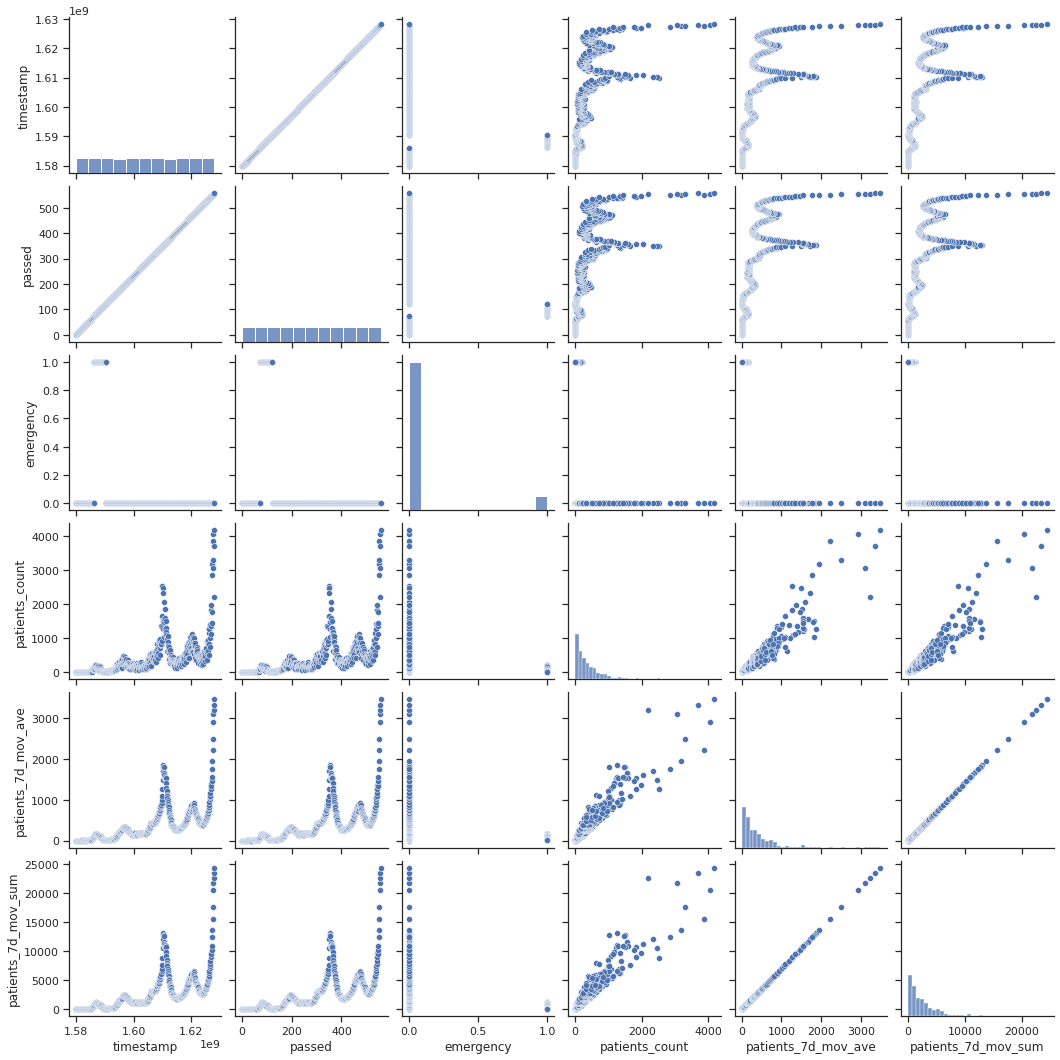

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.11
